# Model Assessment


Term 1 2019 - Instructor: Teerapong Leelanupab

Teaching Assistant: Suttida Satjasunsern

***

Import all of the packages we will need.

In [2]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Our custom libraries!
import sys
sys.path.append("..")
from ds_utils.sample_data import *

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

### Data
We're going to use a mail response data set from a real direct marketing campaign located in `data/mailing.csv`. Each record represents an individual who was targeted with a direct marketing offer.  The offer was a solicitation to make a charitable donation. 

The columns (features) are:

```
income       household income
Firstdate    data assoc. with the first gift by this individual
Lastdate     data associated with the most recent gift 
Amount       average amount by this individual over all periods (incl. zeros)
rfaf2        frequency code
rfaa2        donation amount code
pepstrfl     flag indicating a star donator
glast        amount of last gift
gavr         amount of average gift
```

The target variables is `class` and is equal to one if they gave in this campaign and zero otherwise.

In [3]:
# Load the data
data = pd.read_csv("data/mailing.csv")
# Let's take a look at the data
data.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,rfaa2,pepstrfl,glast,gavr,class
0,3,9409,9509,0.06,1,G,0,50,30.00,0
1,2,9201,9602,0.16,4,G,X,20,20.55,1
2,0,9510,9603,0.20,4,E,0,5,8.75,0
3,6,9409,9603,0.13,2,G,0,25,22.50,0
4,0,9310,9511,0.10,1,G,0,25,12.50,0


From the description above, and the head of the data, we see that two of the fields are **categorical** (text) instead of typical **numerical** fields. Today, one of the models we will be using is a logistic regression. From the previous classes, we have seen that logistic regression requires *all* fields to be numerical. So, we are going to create "dummy" variables for all the fields that are categorical (same as you did for your homework).

#### Dummyize
A dummy variable is a binary variable corresponding to one value of a categorical variable.
The typical way to create dummies for a field is to create new variables for each possible category of the field. For example consider a field called color that can have the possible values "red", "blue", and "green". To dummyize color, we would create three new features: "color_red", "color_blue", and "color_green". These fields would take the value 1 or 0 depending on the actual value of color. Each record can only have one of these fields set to 1.

Notes:

- You can also leave out one of the possible categories. For example, in the above example that had three possible values, you can create only two dummies. This, because when "color_red"=0 and "color_blue"=0 it means that "color_green=1".  Often all three dummies are created anyway; it is slightly redundant, but makes the models more comprehensible.

- There also are cases where non-numeric variables can take on multiple values (for example, `colors = {red, white, blue}`).  In these cases again often binary variables are created for each value, the obvious difference being that now more than one can be non-zero (and you would need to represent all the values).
 

So.  Let's dummyize the fields `rfaa2` and `pepstrfl`.

In [4]:
for field in ['rfaa2', 'pepstrfl']:
    dummies = pd.get_dummies(data[field])
    dummies.columns = [field + "_" + s for s in dummies.columns]
    data = pd.concat([data, dummies], axis=1).drop(field, axis="columns")
    
data.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,glast,gavr,class,rfaa2_D,rfaa2_E,rfaa2_F,rfaa2_G,pepstrfl_0,pepstrfl_X
0,3,9409,9509,0.06,1,50,30.00,0,0,0,0,1,1,0
1,2,9201,9602,0.16,4,20,20.55,1,0,0,0,1,0,1
2,0,9510,9603,0.20,4,5,8.75,0,0,1,0,0,1,0
3,6,9409,9603,0.13,2,25,22.50,0,0,0,0,1,1,0
4,0,9310,9511,0.10,1,25,12.50,0,0,0,0,1,1,0


### Confusion matrices
Let's build a confusion matrix using a logistic regression model. 

**Important and overlooked (always remember this!):** a confusion matrix is defined with respect to a classifier, not a scoring model (e.g., a class-probability estimation model).  Our models *are* scoring models.  So the confusion matrices are defined with respect a scoring model plus a *threshold* on the score.  The threshold should be chosen carefully, and with the business need in mind.   For binary classes, the default for most modeling programs when they return a predicted classification is to use a threshold corresponding to an estimated class probability of 0.5.  This is because the modeling program does not know the business setting, and 0.5 makes sense as a default (in expectation it gives the maximum classification accuracy, if the probabilities are well calibrated).

So let's start with the default of predicting a 1 if the estimated probability is $\geq$ 50% and a 0 otherwise.

Remember, a confusion matrix looks like:

```
  |____________ p __________|___________ n ___________|
Y | 1's predicted to be 1's | 0's predicted to be 1's |
N | 1's predicted to be 0's | 0's predicted to be 0's |
```

In [5]:
# Split our data
X = data.drop(['class'], axis=1)
Y = data['class']
X_mailing_train, X_mailing_test, Y_mailing_train, Y_mailing_test = train_test_split(X, Y, test_size=.25, random_state=42)

# Make and fit a model on the training data
model_mailing = LogisticRegression(C=1000000, solver='liblinear')
model_mailing.fit(X_mailing_train, Y_mailing_train)

# Get probabilities of being a (We saw this last class !!)
probabilities = model_mailing.predict_proba(X_mailing_test)[:, 1]

Use the default threshold of 50% to predict a 1.

(An individual below this threshold will get a label "0" and someone above this will get a label "1")

In [6]:
prediction = probabilities > 0.5

# Build and print a confusion matrix
confusion_matrix_large = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test, prediction, labels=[1, 0]).T,
                                columns=['p', 'n'], index=['Y', 'N'])
print (confusion_matrix_large)

      p      n
Y     0      1
N  2423  45521


Wait -- take a close look at that.  What's going on?

Incidentally, what would be the classification accuracy?

-

-

-

-

-


What if we lower the threshold to 5%?

In [7]:
# Let's move the threshold down
prediction = probabilities > 0.05

# Build and print a confusion matrix
confusion_matrix_small = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test, prediction, labels=[1, 0]).T,
                                columns=['p', 'n'], index=['Y', 'N'])
print (confusion_matrix_small)

      p      n
Y  1556  22844
N   867  22678


***
Is this good performance? How can we tell?

(Incidentally, what would be the classification accuracy now?)

Is 5% the right threshold?  How would we determine that?

### Other measures: Receiver operating characteristic (ROC) curves

In the book, we were trying to predict if customers should be given a credit card.  Let's use that example here now:

- Target: `Y_handson = 1` 
- Three features in `X_handson`: "earning", "geographic", and "experience".

Up until this point, when we need a "single number metric" for generalization performance, we have been using "vanilla" classification accuracy (the number of records correctly classified divided by the total number of records). However, this does not always give us the "best" interpretation of our model's performance for a particular business problem. An alternative way is to visualize and measure the performance of a model using the Reciever Operating Characteristic **(ROC) curve**. 

Let's first specify how we create them: For each threshold $t$ that is chosen, we can define two quantities. First, the false positive rate, $FPR = \frac{False Positives}{False Positives+True Negatives}$, and second, the true positive rate, $TPR = \frac{True Positives}{True Positives+False Negatives}$. The ROC curve is the result of plotting $FPR$ against $TPR$ for each value of $t$ that is possible in the data.  It helps us to visualize and analyze the trade-offs between the opportunity for benefits (via true positives) and the possibility of costs (via false positives). 

" The lower left point **(0, 0) represents the strategy of never issuing a positive classification**; such a classifier commits no false positive errors but also gains no true positives. The opposite strategy, of unconditionally issuing positive classifications, is represented by the upper right point (1, 1). The point **(0, 1) represents perfect classification** (the star in Figure 8-3). The diagonal line connecting (0, 0) to (1, 1) represents the policy of guessing a class (for example, by flipping a weighted coin). "  

- _Provost, Foster, and Tom Fawcett. Data Science for Business: _
  _What you need to know about data mining and data-analytic thinking. O'Reilly Media, Inc., 2013._



<img src="images/ROC1.png" alt="Drawing" style="width: 600px;"/>
<img src="images/ROC2.png" alt="Drawing" style="width: 600px;"/>
<img src="images/ROC3.png" alt="Drawing" style="width: 600px;"/>


Doing this in **sklearn** is relatively straightforward.

Let's create a **new DATA SET** for this, that will show differences between different models.  We will build logistic regression models with different regularization parameters.

In [8]:
X, Y = get_dummy_data()

We can now build and fit a model. Using this model, we will plot a *ROC curve*. 

Why are we taking the mean from the `cross_validation.cross_val_score` output?

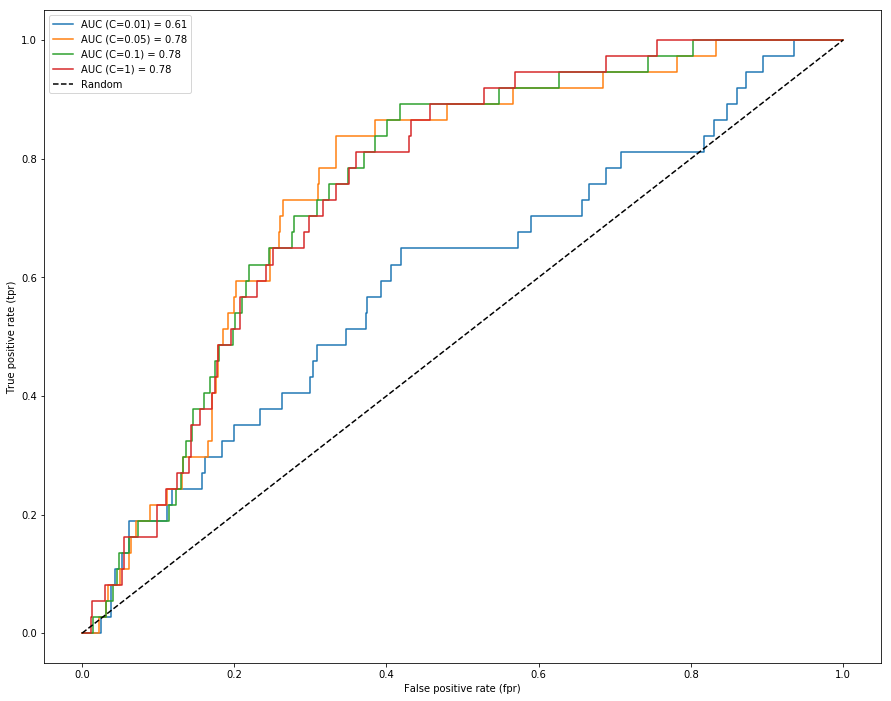

In [9]:
#Split train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

# Fit a logistic regression model
for c in [0.01, 0.05, .1, 1]:
    model = LogisticRegression(C=c, solver='liblinear')
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

### Other measures: Cumulative response and lift curves
The interpretation of an ROC curve is not be entirely intuitive to business stakeholders. In many applications the **cumulative response curve** is more appropriate.  


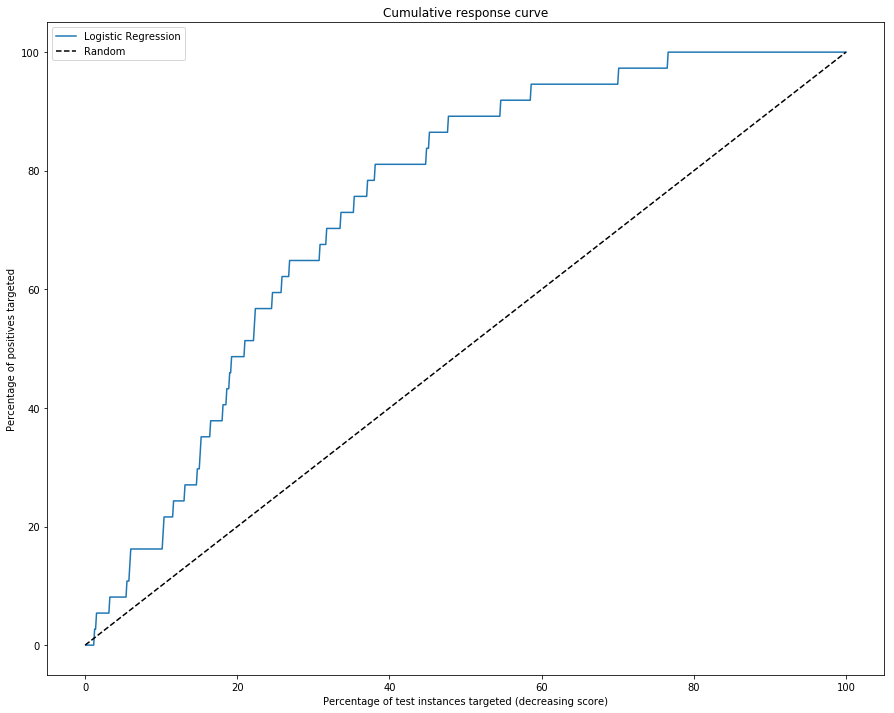

In [10]:
def build_cumulative_curve(model, scale=100):
    # Fit model
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Sort theseprobabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probability_1)[::-1]
    Y_test_probability_1_sorted = Y_test_probability_1[order]
    Y_test_sorted = np.array(Y_test)[order]

    # Build the cumulative response curve
    x_cumulative = np.arange(len(Y_test_probability_1_sorted)) + 1
    y_cumulative = np.cumsum(Y_test_sorted)

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale
    y_cumulative = np.array(y_cumulative)/float(y_cumulative.max()) * scale
    
    return x_cumulative, y_cumulative

def plot_cumulative_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [0,100], 'k--', label="Random")
    plt.xlabel("Percentage of test instances targeted (decreasing score)")
    plt.ylabel("Percentage of positives targeted")
    plt.title("Cumulative response curve")
    plt.legend()

models = {"Logistic Regression": LogisticRegression(C=1.0, solver="liblinear")}
plot_cumulative_curve(models)

We can also easily plot a **lift curve** in this scenario.

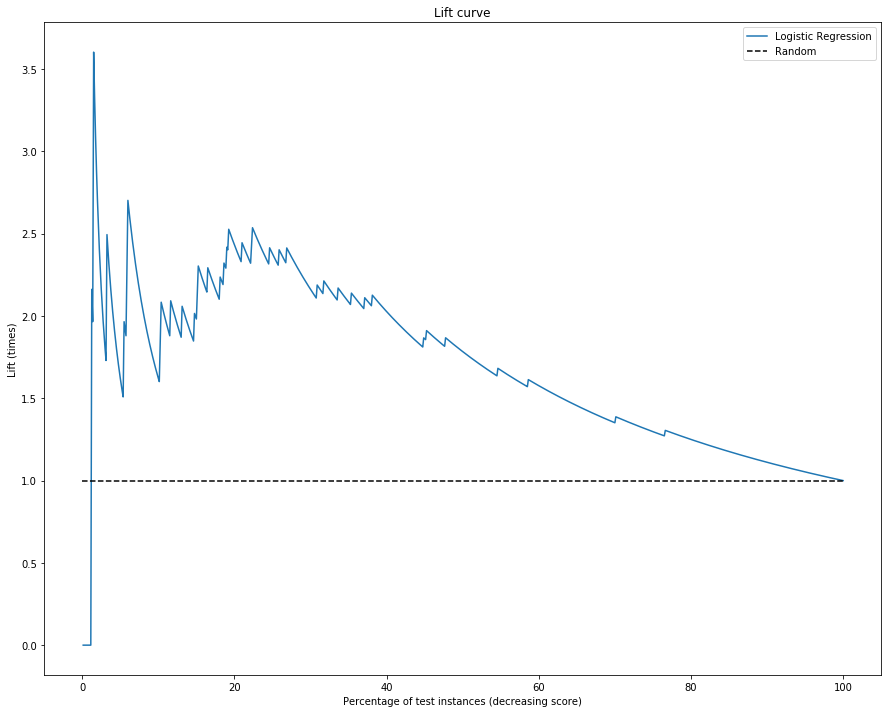

In [11]:
def plot_lift_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative/x_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [1,1], 'k--', label="Random")
    plt.xlabel("Percentage of test instances (decreasing score)")
    plt.ylabel("Lift (times)")
    plt.title("Lift curve")
    plt.legend()

plot_lift_curve(models)

Let's revisit our **mailing dataset** compare the cumulative response curves and then the lift curves of two models (a logistic regression model and a tree).

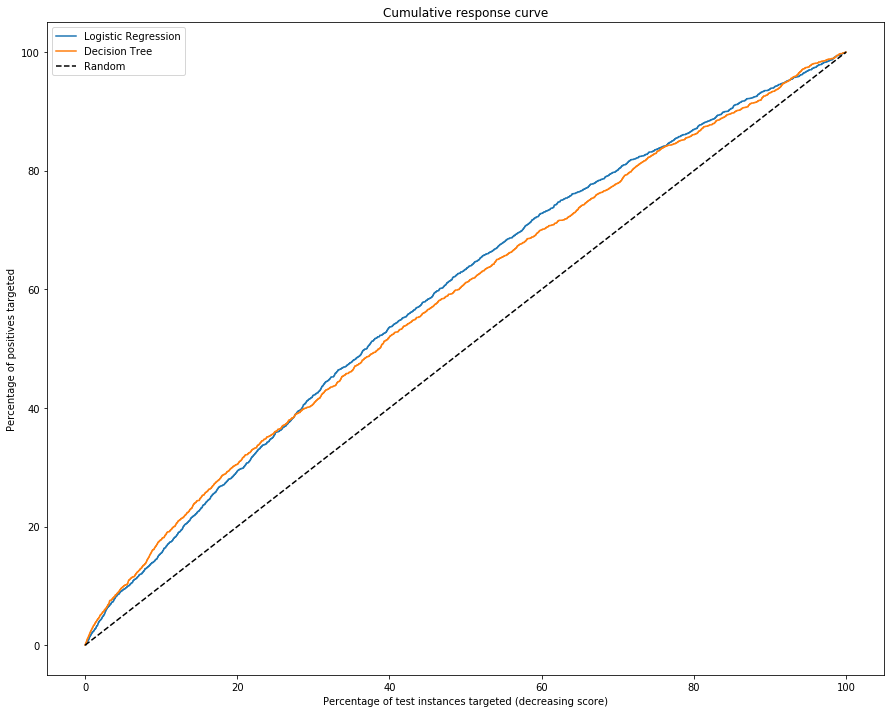

In [12]:
X_train, X_test, Y_train, Y_test = X_mailing_train, X_mailing_test, Y_mailing_train, Y_mailing_test

models = {"Logistic Regression": LogisticRegression(C=1.0, solver="liblinear"), 
          "Decision Tree": DecisionTreeClassifier(criterion="entropy", min_samples_leaf=300, random_state=42)}
plot_cumulative_curve(models)

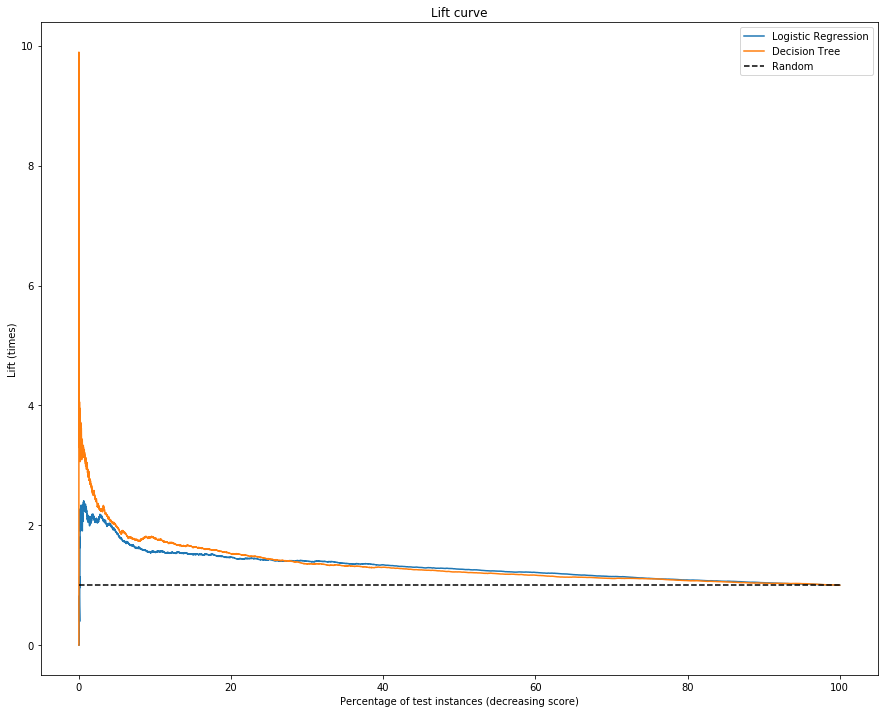

In [13]:
plot_lift_curve(models)

What if we want to understand not just lift, but how much benefit we are going to receive from a certain investment in targeting?  We can plot a profit curve.


### Profit curves
Let's say that each offer costs \\$1 to make and market, and each accepted offer earns \\$18, for a profit of \\$17. The cost matrix would be:


In [14]:
unit_cost = 1
unit_revenue = 18

cost_matrix = pd.DataFrame([[unit_revenue - unit_cost, - unit_cost], [0, 0]], columns=['p', 'n'], index=['Y', 'N'])
print ("Cost matrix")
print (cost_matrix)

Cost matrix
    p  n
Y  17 -1
N   0  0


Remember that we examined different targeting thresholds: 

In [15]:
print ("Confusion matrix with threshold = 50% to predict labels")
print (confusion_matrix_large)
print ("\n")
print ("Confusion matrix with threshold = 5% to predict labels")
print (confusion_matrix_small)

Confusion matrix with threshold = 50% to predict labels
      p      n
Y     0      1
N  2423  45521


Confusion matrix with threshold = 5% to predict labels
      p      n
Y  1556  22844
N   867  22678



Based on those predictions, the expected profit of using 50% and 5% as your prediction threshold would be.\

In [16]:
profit_in_large = np.sum((confusion_matrix_large * cost_matrix).values)
profit_in_small = np.sum((confusion_matrix_small * cost_matrix).values)

print ("Expected profit per targeted individual with a cutoff of 50%% is $%.2f." % profit_in_large)
print ("Expected profit per targeted individual with a cutoff of 5%% is $%.2f." % profit_in_small)

Expected profit per targeted individual with a cutoff of 50% is $-1.00.
Expected profit per targeted individual with a cutoff of 5% is $3608.00.


The following would be a profit curve.

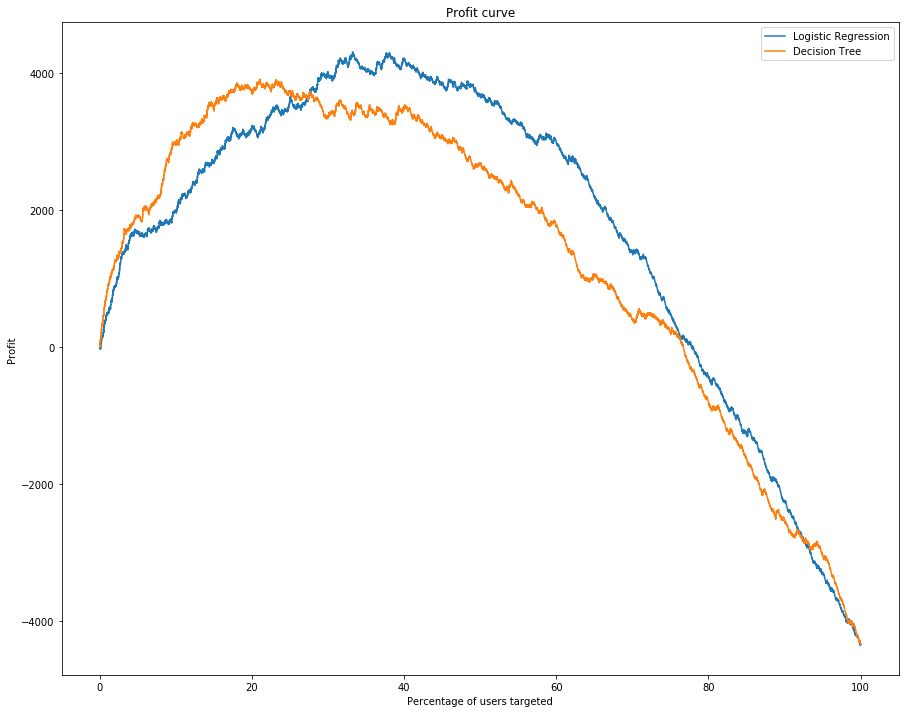

In [17]:
unit_cost = -cost_matrix['n']['Y']
unit_revenue = cost_matrix['p']['Y'] + unit_cost

def plot_profit_curve(models):
    # Plot curve for each model
    total_obs = len(Y_test)
    total_pos = Y_test.sum()
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key], scale=1)
        profits = unit_revenue * y_cumulative * total_pos - unit_cost * x_cumulative * total_obs
        plt.plot(x_cumulative*100, profits, label=key)
    # Plot other details
    plt.xlabel("Percentage of users targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend()
    
plot_profit_curve(models)

Which one do you think we should choose? Why?